# Solution

## Goal
Compute the expected payout when you may roll a fair 6-sided die up to three times, and you are paid the maximum value observed (stopping early if a 6 is rolled).

## Problem Statement
You can roll a 6-sided die at most three times. Your payout is $X$, the highest roll you obtain. You may stop rolling early if you roll a 6. Find $\mathbb{E}[X]$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)

## Key idea: distribution of the maximum
Let $M$ be the maximum of the (up to) three rolls.

Even though the process *stops early* if we roll a 6, the random variable $M$ has the same distribution as the maximum of **three independent** die rolls: if a 6 appears, the maximum is already 6 and additional rolls cannot change $M$.

### CDF method
For $m \in \{1,\dots,6\}$:

$$\Pr(M \le m) = \Pr(\text{all 3 rolls are} \le m) = \left(\frac{m}{6}\right)^3.$$

Convert to a PMF using differences:

$$\Pr(M=m) = \Pr(M \le m) - \Pr(M \le m-1).$$

Finally,

$$\mathbb{E}[M] = \sum_{m=1}^{6} m\,\Pr(M=m).$$

## Combinatorial derivation (matches the $\sum \binom{3}{k}(i-1)^{3-k}$ formula)
Let’s count outcomes for the maximum when we conceptually roll **three times** (even if we would stop early on a 6). All $6^3=216$ length-3 sequences are equally likely.

Fix $i\in\{1,\dots,6\}$. The event $\{M=i\}$ means:
- all rolls are in $\{1,\dots,i\}$, and
- at least one roll equals $i$.

A clean count is:

$$\#\{M=i\} = i^3-(i-1)^3.$$

This also equals your “place the max value $i$ exactly $k$ times” sum:

$$\#\{M=i\} = \sum_{k=1}^{3} \binom{3}{k}(i-1)^{3-k}.$$

Reason: choose which $k$ positions contain the value $i$ ($\binom{3}{k}$ ways), and fill the remaining $3-k$ positions with any value in $\{1,\dots,i-1\}$ ($(i-1)^{3-k}$ ways).

By the binomial theorem, $\sum_{k=0}^{3} \binom{3}{k}(i-1)^{3-k} = (i-1+1)^3=i^3$, so removing the $k=0$ term ($(i-1)^3$) gives exactly $i^3-(i-1)^3$.

This reproduces the familiar counts:
- $i=2$: $2^3-1^3=7$
- $i=3$: $3^3-2^3=19$
- $i=4$: $4^3-3^3=37$
- $i=5$: $5^3-4^3=61$
- $i=6$: $6^3-5^3=91$

**Important:** if you count “stopping paths” for $i=6$ you may get $1+5+25=31$, but those paths are *not* equally likely compared to length-3 sequences. For expectation, it’s safest to work with probabilities (CDF/PMF) or with the 216 equally-likely length-3 roll sequences.

In [2]:
# Exact PMF via CDF differences
m = np.arange(1, 7)
cdf = (m / 6) ** 3
cdf_prev = np.concatenate(([0.0], cdf[:-1]))
pmf = cdf - cdf_prev

df = pd.DataFrame({"m": m, "P(M=m)": pmf})
df["m * P(M=m)"] = df["m"] * df["P(M=m)"]

expected_value = df["m * P(M=m)"].sum()
expected_value_fraction = int(round(expected_value * 216)), 216  # since denominators are 6^3
expected_value, expected_value_fraction, df

(np.float64(4.958333333333333),
 (1071, 216),
    m    P(M=m)  m * P(M=m)
 0  1  0.004630    0.004630
 1  2  0.032407    0.064815
 2  3  0.087963    0.263889
 3  4  0.171296    0.685185
 4  5  0.282407    1.412037
 5  6  0.421296    2.527778)

## Common pitfall: counting outcomes after early stopping
A frequent mistake is to treat all *observed* roll sequences as equally likely when early stopping is allowed (they are not).

Example:
- Sequence `6` (stop on the first roll) has probability $1/6$.
- Sequence `1, 2, 3` (no early stop) has probability $(1/6)^3 = 1/216$.

Because different-length paths have different probabilities, you cannot count “paths” and divide by the number of paths unless all paths have the same probability.

This is exactly why a path-counting approach can produce an incorrect value like ~$4.56$: it implicitly assumes each stopping path is equally likely.

The cleanest approach is to work directly with probabilities using the CDF method for $M$ shown above.

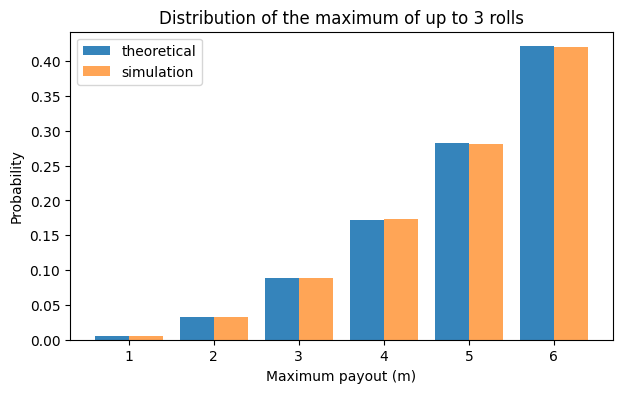

In [4]:
def simulate_max_payout(n: int, rng: np.random.Generator) -> np.ndarray:
    """Simulate the process: roll up to 3 times, stop early if a 6 is rolled; payout is the maximum seen."""
    payouts = np.empty(n, dtype=int)
    for i in range(n):
        current_max = 0
        for _ in range(3):
            roll = int(rng.integers(1, 7))  # 1..6 inclusive
            if roll > current_max:
                current_max = roll
            if roll == 6:
                break
        payouts[i] = current_max
    return payouts

n = 200_000
payouts = simulate_max_payout(n=n, rng=rng)
sim_mean = payouts.mean()
sim_mean, expected_value, sim_mean - expected_value

# Empirical vs theoretical PMF
emp_counts = np.bincount(payouts, minlength=7)[1:]
emp_pmf = emp_counts / emp_counts.sum()

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(m - 0.2, pmf, width=0.4, label="theoretical", alpha=0.9)
ax.bar(m + 0.2, emp_pmf, width=0.4, label="simulation", alpha=0.7)
ax.set_xticks(m)
ax.set_xlabel("Maximum payout (m)")
ax.set_ylabel("Probability")
ax.set_title("Distribution of the maximum of up to 3 rolls")
ax.legend()
plt.show()

## Conclusion
The maximum after three fair die rolls has PMF
$$\Pr(M=m)=\left(\frac{m}{6}\right)^3-\left(\frac{m-1}{6}\right)^3,$$
so the expected payout is
$$\mathbb{E}[M] = \frac{1071}{216} \approx 4.9583.$$

A simulation that stops early on 6 matches this value (up to Monte Carlo error), confirming that “stop on 6” does not change the distribution of the maximum.